In [33]:
import torch
import torchaudio
import torch.nn.functional as F
import torchaudio.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader

import numpy as np
import librosa
import librosa.display

import matplotlib.pyplot as plt

from IPython.display import Audio, display
from transforms.unpacking import RawToTensorFloat32
from data.datasets import ArcticDataset, TIMITDataset
from tqdm import tqdm

print(torch.__version__)
print(torchaudio.__version__)

1.7.1+cu110
0.7.2


# CUDA

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Dataset

In [3]:
timit_dataset_train = TIMITDataset(usage='train',root_dir='/media/maxim/Programming/voice_datasets/timit/TIMIT_2/data', transform=RawToTensorFloat32())

timit_dataset_test = TIMITDataset(usage='test',root_dir='/media/maxim/Programming/voice_datasets/timit/TIMIT_2/data', transform=RawToTensorFloat32())

In [5]:
print(len(timit_dataset_train))
print(len(timit_dataset_test))
print(timit_dataset_train[0])
item = 120
timit_waveform = timit_dataset_train[item].data
timit_framerate = timit_dataset_train[item].frame_rate

177080
64145
AudioFragment(data=tensor([ 3.0518e-05, -3.0518e-05,  6.1035e-05,  ...,  6.1035e-05,
        -1.2207e-04, -2.1362e-04]), label='H#', frame_rate=16000, sample_width=2)


In [6]:
labels = sorted(list(set(datapoint.label for datapoint in timit_dataset_train)))
labels

['AA',
 'AE',
 'AH',
 'AO',
 'AW',
 'AX',
 'AX-H',
 'AXR',
 'AY',
 'B',
 'BCL',
 'CH',
 'D',
 'DCL',
 'DH',
 'DX',
 'EH',
 'EL',
 'EM',
 'EN',
 'ENG',
 'EPI',
 'ER',
 'EY',
 'F',
 'G',
 'GCL',
 'H#',
 'HH',
 'HV',
 'IH',
 'IX',
 'IY',
 'JH',
 'K',
 'KCL',
 'L',
 'M',
 'N',
 'NG',
 'NX',
 'OW',
 'OY',
 'P',
 'PAU',
 'PCL',
 'Q',
 'R',
 'S',
 'SH',
 'T',
 'TCL',
 'TH',
 'UH',
 'UW',
 'UX',
 'V',
 'W',
 'Y',
 'Z',
 'ZH']

# Transforms

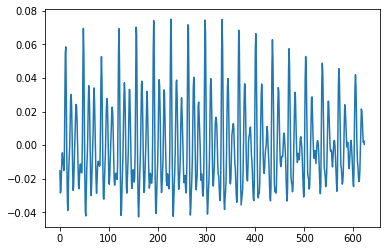

In [7]:
transform = T.Resample(orig_freq=timit_framerate, new_freq=8000)

transformed = transform(timit_waveform)
display(Audio(transformed.numpy(), rate=8000))
plt.plot(transformed.t().numpy());

# Formatting

In [8]:
def label_to_index(phone):
    # Return the position of the word in labels
    return torch.tensor(labels.index(phone))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


phone_start = "EY"
index = label_to_index(phone_start)
word_recovered = index_to_label(index)

print(phone_start, "-->", index, "-->", word_recovered)

EY --> tensor(23) --> EY


In [28]:
def pad_sequence(batch):

    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(1, 0)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    timit_dataset_train,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    timit_dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([10208, 256])
Labels batch shape: torch.Size([256])
tensor([[-1.6479e-03,  3.6621e-04,  1.2207e-03,  ..., -3.3783e-02,
         -2.4414e-04, -3.5095e-03],
        [-1.7700e-03,  2.1362e-04,  2.7466e-04,  ..., -3.8391e-02,
          5.4932e-04, -3.3569e-03],
        [-2.0447e-03,  1.2207e-04, -6.1035e-05,  ..., -3.7079e-02,
          5.1880e-04, -2.4414e-03],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])


# Models

## M5

In [29]:
from torch import nn

class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(624, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=61, bias=True)
)
Num

In [30]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

## Train and test

In [32]:
log_interval = 20
n_epoch = 2

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

In [37]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        print(data.size(), data)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

In [35]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

In [38]:

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([9760, 256]) tensor([[-0.0009, -0.0022, -0.0147,  ..., -0.0067,  0.0066, -0.0009],
        [-0.0018, -0.0027, -0.0108,  ..., -0.0046,  0.0255,  0.0006],
        [-0.0013, -0.0031, -0.0039,  ..., -0.0017,  0.0334,  0.0019],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')


RuntimeError: Expected 3-dimensional input for 3-dimensional weight [32, 624, 80], but got 2-dimensional input of size [9760, 128] instead